In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchaudio import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [ ]:
train_data = datasets.SPEECHCOMMANDS(root='./data', download=True, subset='training')
test_data = datasets.SPEECHCOMMANDS(root='./data', download=True, subset='testing')
valid_data = datasets.SPEECHCOMMANDS(root='./data', download=True, subset='validation')

100%|██████████| 2.26G/2.26G [00:18<00:00, 129MB/s]


In [ ]:
label = list(set([i[2] for i in train_data]))
label

['bed',
 'four',
 'happy',
 'nine',
 'zero',
 'go',
 'eight',
 'down',
 'house',
 'bird',
 'off',
 'marvin',
 'on',
 'up',
 'sheila',
 'visual',
 'follow',
 'cat',
 'yes',
 'tree',
 'learn',
 'six',
 'no',
 'left',
 'one',
 'two',
 'stop',
 'seven',
 'backward',
 'three',
 'dog',
 'wow',
 'five',
 'forward',
 'right']

In [ ]:
len(label)

35

In [ ]:
label_to_index = {
    label:ind # create key:value
    for ind, label in enumerate(label)
    }
label_to_index

{'bed': 0,
 'four': 1,
 'happy': 2,
 'nine': 3,
 'zero': 4,
 'go': 5,
 'eight': 6,
 'down': 7,
 'house': 8,
 'bird': 9,
 'off': 10,
 'marvin': 11,
 'on': 12,
 'up': 13,
 'sheila': 14,
 'visual': 15,
 'follow': 16,
 'cat': 17,
 'yes': 18,
 'tree': 19,
 'learn': 20,
 'six': 21,
 'no': 22,
 'left': 23,
 'one': 24,
 'two': 25,
 'stop': 26,
 'seven': 27,
 'backward': 28,
 'three': 29,
 'dog': 30,
 'wow': 31,
 'five': 32,
 'forward': 33,
 'right': 34}

In [ ]:
transform = transforms.MelSpectrogram(
    sample_rate=16000,
    n_mels=64
)

In [ ]:
max_len = 100
def change_audio(audio):
    spectrograms, classes = [], []
    for waveform, sample_rate, label, *_ in audio:
        spec_audio = transform(waveform).squeeze(0)
        if spec_audio.shape[1] > max_len:
            spec_audio = spec_audio[:, :max_len]
        if spec_audio.shape[1] < max_len:
            count_len = max_len - spec_audio.shape[1]
            spec_audio = F.pad(spec_audio, (0, count_len))
        spectrograms.append(spec_audio)
        classes.append(label_to_index[label])
    spectrograms = torch.stack(spectrograms)
    targets = torch.tensor(classes)
    return spectrograms, targets

In [ ]:
train = DataLoader(train_data, batch_size=64, shuffle=True, collate_fn=change_audio)
test = DataLoader(test_data, batch_size=64, collate_fn=change_audio)

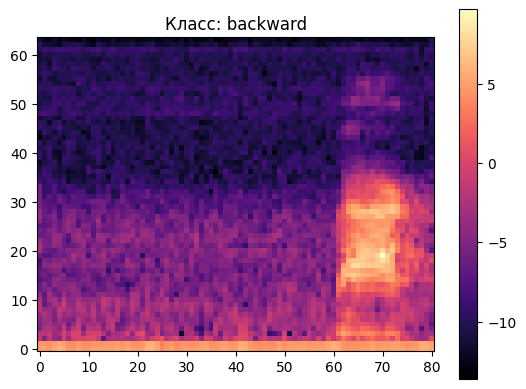

In [ ]:
waveform, sample_rate, label, *_ = train_data[0]
spec = transform(waveform).squeeze(0).float()
plt.imshow(spec.log2().numpy(), cmap='magma', origin='lower')
plt.title(f'Класс: {label}')
plt.colorbar()
plt.show()

In [ ]:
class CheckAudio(nn.Module):
    def __init__(self,):
        super().__init__()
        self.first = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.AdaptiveAvgPool2d((8, 8))
        )
        self.second = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 8 * 8, 128),
            nn.ReLU(),
            nn.Linear(128, 35)
        )
    def forward(self, audio):
        audio = audio.unsqueeze(1)
        audio = self.first(audio)
        audio = self.second(audio)
        return audio

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
model = CheckAudio().to(device)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
for epoch in range(22):
    model.train()
    total_loss = 0
    for x_batch, y_batch in train:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_pred = model(x_batch)
        loss = loss_fn(y_pred, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f'Эпоха: {epoch + 1}, Потери: {round(total_loss, 2)}%')

/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be r

Эпоха: 1, Потери: 2917.92%
Эпоха: 2, Потери: 1522.49%
Эпоха: 3, Потери: 1152.24%
Эпоха: 4, Потери: 968.93%
Эпоха: 5, Потери: 838.85%
Эпоха: 6, Потери: 760.79%
Эпоха: 7, Потери: 694.43%
Эпоха: 8, Потери: 632.57%
Эпоха: 9, Потери: 605.92%
Эпоха: 10, Потери: 561.66%
Эпоха: 11, Потери: 525.9%
Эпоха: 12, Потери: 502.94%
Эпоха: 13, Потери: 469.69%
Эпоха: 14, Потери: 452.18%
Эпоха: 15, Потери: 428.86%
Эпоха: 16, Потери: 405.83%
Эпоха: 17, Потери: 397.48%
Эпоха: 18, Потери: 359.8%
Эпоха: 19, Потери: 351.37%
Эпоха: 20, Потери: 360.67%
Эпоха: 21, Потери: 334.34%
Эпоха: 22, Потери: 306.89%


In [ ]:
from sklearn.metrics import accuracy_score

model.eval()
correct, total = 0, 0

with torch.no_grad():
    for x_batch, y_batch in test:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_pred = model(x_batch)
        pred = torch.argmax(y_pred, dim=1)

        total += y_batch.size(0)
        correct += (pred == y_batch).sum().item()

accuracy = correct * 100 / total
print(f'Тотал модели на тестовых данных: {round(accuracy, 2)}%')

/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be r

Тотал модели на тестовых данных: 82.76%


In [ ]:
torch.save(model.state_dict(), 'audioCpeechCommands_model.pth')
torch.save(label, 'label.pth')

In [ ]:
from google.colab import files
files.download('audioCpeechCommands_model.pth')
files.download('label.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>